# Simulating sound changes in real and artificial lexicons

This aims to address several questions:
1. Does simulating sound changes in a lexicon result in more homophones overall?
2. Do simulated changes result in more homophones for *short* words than *long* words?

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import src.utils as utils
import numpy as np
from collections import Counter

import itertools
from tqdm import tqdm
import seaborn as sns

In [2]:
from src.generative_model import *

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

# English


### Load and preprocess data


In [4]:
df_celex = pd.read_csv("data/processed/english/english_all_reals.csv")

In [5]:
len(df_celex)

52438

In [6]:
df_celex_processed = pd.read_csv("data/processed/english/english_lemmas_processed.csv")
len(df_celex_processed)

35107

## Get baseline info

In [7]:
FORMULA = 'num_homophones ~ surprisal + num_sylls_est'
COVARIATES = ['surprisal', 'num_sylls_est']
COVARIATE_LABELS = ['surprisal', '#syllables']
LANGUAGE = 'English'

In [8]:
baseline_descriptive_stats = utils.get_homophone_stats(df_celex_processed)

In [9]:
baseline_model_stats = utils.analyze_stats_for_single(df_celex_processed, formula=FORMULA, covariates=COVARIATES)
baseline_model_stats

,Intercept,surprisal,num_sylls_est
0,1.308477,-0.203636,-0.871333


## Create phonotactic model to recalculate surprisal

In [10]:
def create_model(wordforms, n=5, smoothing=.01):
    """Create n-gram model."""
    lm = NgramModel(n, wordforms, 1)
    lm.create_model(wordforms, smoothing)
    return lm

In [11]:
unique_wordforms = list(df_celex_processed['PhonDISC'])
model = create_model(unique_wordforms, n=5, smoothing=.01)

## Implement sound changes

Now we construct a set of sound changes that can occur in a lexicon. For now, we simulate *unconditioned* sound change: that is, what happens when a single phone changes to another phone *across* the lexicon?

[Link to PhonDISC](http://groups.linguistics.northwestern.edu/speech_comm_group/documents/CELEX/Phonetic%20codes%20for%20CELEX.pdf)



### Attested sound changes in English (and Germanic languages more generally) 

[This chart](https://en.wikipedia.org/wiki/Phonological_history_of_English#Examples_of_sound_changes) illustrates examples of sound changes in the history of English. 


#### [Grimm's Law](https://en.wikipedia.org/wiki/Grimm's_law#Examples): transition from Proto-Indo-European to Proto-Germanic.

```
Grimm's law consists of three parts which form consecutive phases in the sense of a chain shift.[1] The phases are usually constructed as follows:

This chain shift (in the order 3,2,1) can be abstractly represented as:

    bʰ > b > p > ɸ
    dʰ > d > t > θ
    gʰ > g > k > x
    gʷʰ > gʷ > kʷ > xʷ
 ```
Examples:  
* /b/ --> /p/
* /d/ --> /t/
* /g/ --> /k/
* /p/ --> /f/
* /t/ --> /th/
* /k/ --> /h/


#### [Great vowel Shift](https://en.wikipedia.org/wiki/Great_Vowel_Shift#Overall_changes)

Examples:  
* /iː/ --> /aI/  ('i', '2')  
* /eː/ --> /iː/  ('3', 'i')  
* /aː/ --> /eɪ/  ('#', '1')  
* /uː/ --> /aʊ/  ('u', '5')  
* /oː/ --> /uː/  ( , 'u')
* /ɔː/ --> /oʊ/  ('$', '5') 



### Questions

**Q1**: Should the chain-based changes in Grimm's Law be applied in succession, as they occurred? E.g., b-->p-->f?

**Q2**: Finish transcribing Vowel Shift.

In [12]:
vowels = list(set("i#$u312456789IE{QVU@cq0~"))
len(vowels)

24

In [13]:
phonological_inventory = list(set(''.join(df_celex_processed['PhonDISC'])))
len(phonological_inventory)

53

In [14]:
consonants = [j for j in phonological_inventory if j not in vowels]
len(consonants)

29

In [15]:
consonant_swaps = list(itertools.permutations(consonants, 2))
vowel_swaps = list(itertools.permutations(vowels, 2))

In [16]:
potential_swaps = consonant_swaps + vowel_swaps
len(potential_swaps)

1364

In [17]:
grimms_law = [('b', 'p'),
              ('d', 't'),
             ('g', 'k'),
             ('p', 'f'),
             ('t', 'T'),
             ('k', 'h')]

In [18]:
great_vowel_shift = [ ('i', '2') ,
                    ('3', 'i'),
                     ('#', '1'),
                    ('u', '5') ,
                     ('$', '5')]

In [19]:
potential_swaps = grimms_law + great_vowel_shift

In [20]:
def implement_unconditioned_sound_change(wordforms, rule):
    """Implement sound change across a lexicon of phonological wordforms.
    
    Parameters
    ----------
    wordforms: list
       list of strings representing phonological wordforms
    rule: tuple
       tuple with first element representing original sound, second 
       representing new sound
    """
    new_wordforms = [word.replace(rule[0], rule[1]) for word in wordforms]
    return new_wordforms

### Simulate sound changes in real English

Now we simulate sound changes starting from the same initial conditions.

In [21]:
import random

In [22]:
descriptive_stats, model_stats = [], []

In [23]:
# for rule in tqdm(rules):# tqdm(potential_swaps[0:10]):
for rule in tqdm(potential_swaps):

    df_copy = df_celex.copy()
    df_copy['new_lexicon'] = implement_unconditioned_sound_change(list(df_copy['PhonDISC']), rule)
    df_copy['unchanged'] = df_copy['new_lexicon'] == df_copy['PhonDISC']
    
    # Reprocess
    df_copy_processed = utils.preprocess_for_analysis(df_copy, phon_column='new_lexicon')
    new_lexicon_stats = utils.get_homophone_stats(df_copy_processed)
    descriptive_stats.append(new_lexicon_stats)
    
    # Recalculate surprisal for changed words
    df_copy_processed['surprisal'] = df_copy_processed['new_lexicon'].apply(lambda x: -model.evaluate(x)[2])
    
    new_model_stats = utils.analyze_stats_for_single(df_copy_processed, formula=FORMULA, covariates=COVARIATES)
    model_stats.append(new_model_stats)

  0%|          | 0/11 [00:00<?, ?it/s]/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
100%|██████████| 11/11 [00:16<00:00,  1.43s/it]


In [24]:
df_model_stats = pd.concat(model_stats)

In [25]:
df_descriptive = pd.DataFrame(descriptive_stats)

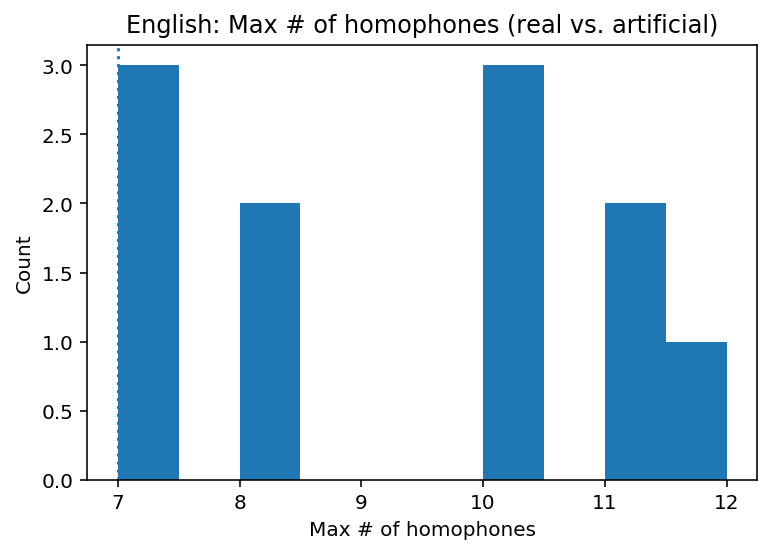

In [26]:
utils.plot_real_vs_art(df_descriptive['max_homophones'], baseline_descriptive_stats['max_homophones'],
                'Max # of homophones', language="English")

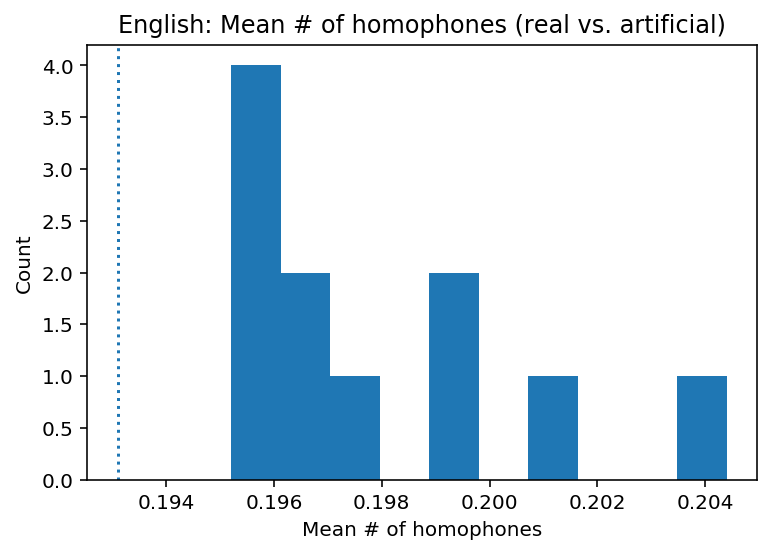

In [27]:
utils.plot_real_vs_art(df_descriptive['mean_homophones'], baseline_descriptive_stats['mean_homophones'],
                'Mean # of homophones', language="English")

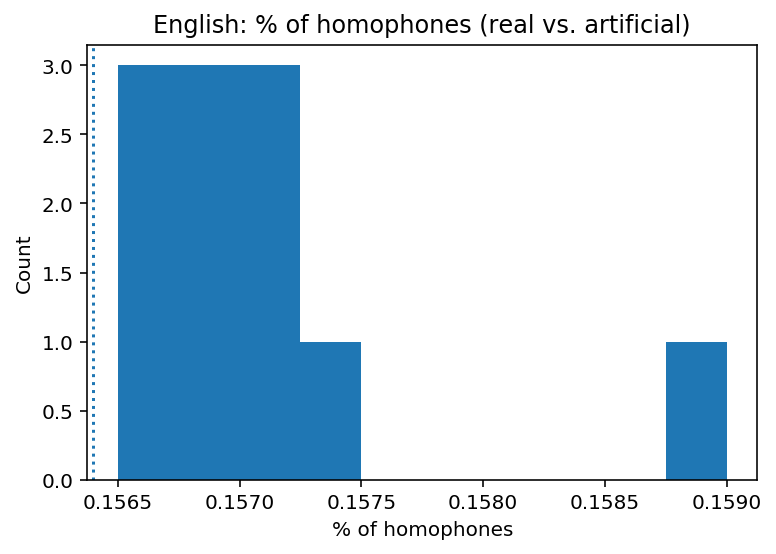

In [28]:
utils.plot_real_vs_art(df_descriptive['homophone_percentage'], baseline_descriptive_stats['homophone_percentage'],
                '% of homophones', language="English")

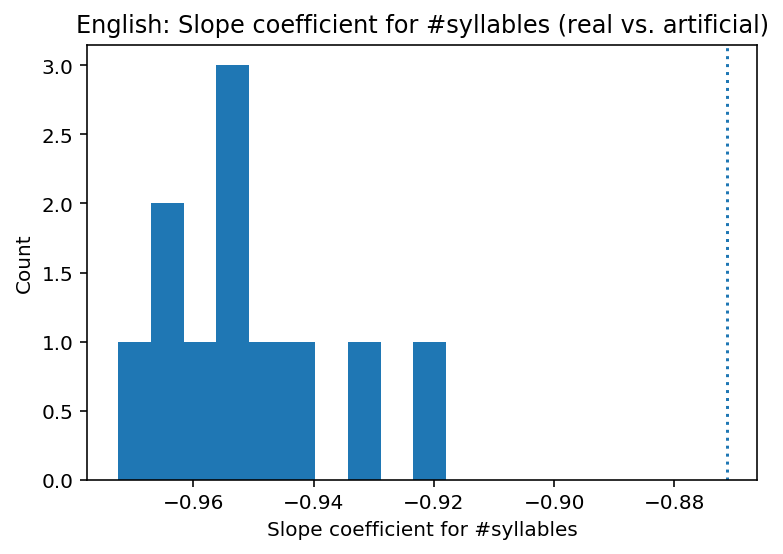

In [29]:
utils.plot_real_vs_art(df_model_stats['num_sylls_est'], baseline_model_stats['num_sylls_est'].values,
                'Slope coefficient for #syllables', language="English")

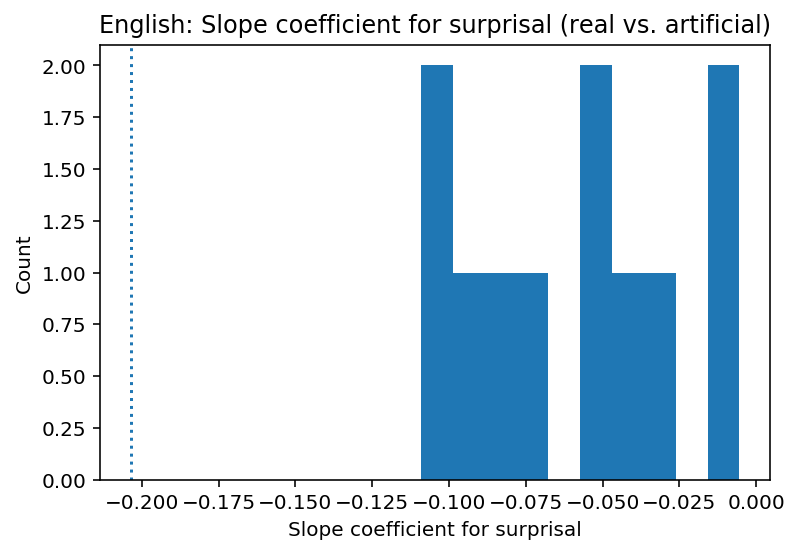

In [30]:
utils.plot_real_vs_art(df_model_stats['surprisal'], baseline_model_stats['surprisal'].values,
                'Slope coefficient for surprisal', language="English")

## Simulate sound changes in artificial lexicons

Now we simulate sound changes in artificial lexicons.

In [31]:
def apply_sound_change(df, rule):
    """Apply sound change and recalculate stats."""
    df_copy = df.copy()
    df_copy['new_lexicon'] = implement_unconditioned_sound_change(list(df_copy['word']), rule)
    df_copy['unchanged'] = df_copy['new_lexicon'] == df_copy['word']

    # Reprocess
    df_copy_processed = utils.preprocess_for_analysis(df_copy, phon_column='new_lexicon', word_column="new_lexicon")
    new_lexicon_stats = utils.get_homophone_stats(df_copy_processed)
    # new_lexicon_stats['n'] = index
    # descriptive_stats.append(new_lexicon_stats)

    # Recalculate surprisal for changed words
    df_copy_processed['surprisal'] = df_copy_processed['new_lexicon'].apply(lambda x: -model.evaluate(x)[2])

    baseline_model_stats = utils.analyze_stats_for_single(df_copy_processed, formula=FORMULA, covariates=COVARIATES)
    # baseline_model_stats['n'] = index
    # model_stats.append(baseline_model_stats)
    
    return df_copy, new_lexicon_stats, baseline_model_stats

### Establish baselines for each lexicon

Determine the baseline %homophonous wordforms, slope coefficients, etc., for each artificial lexicon. Then we can ask about how many sound changes it takes to get from this baseline to the real slope coefficient.

In [32]:
df_artificials = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls.csv")

In [33]:
individual_artificials = [df_artificials[df_artificials['lexicon']==i] for i in range(10)]
processed_artificials = []
for art in tqdm(individual_artificials):
    processed_artificials.append(utils.preprocess_for_analysis(art, phon_column="word", word_column="word"))

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [34]:
baseline_artificial_stats = []
for index, art in enumerate(processed_artificials):
    baseline_descriptive_stats_art = utils.get_homophone_stats(art)
    baseline_descriptive_stats_art['n'] = index
    baseline_artificial_stats.append(baseline_descriptive_stats_art)

df_artificial_descriptive_stats = pd.DataFrame(baseline_artificial_stats)

In [35]:
baseline_artificial_model_stats = []
for index, art in enumerate(processed_artificials):
    baseline_model_stats_art = utils.analyze_stats_for_single(art, formula=FORMULA, covariates=COVARIATES)
    baseline_model_stats_art['n'] = index
    baseline_artificial_model_stats.append(baseline_model_stats_art)

df_artificial_baseline_models = pd.concat(baseline_artificial_model_stats)

### Individual sound changes

Here the question is: What's the average impact of different sound changes on the coefficient for `num_sylls_est`?

In [36]:
descriptive_stats_art, model_stats_art = [], []

In [37]:
for index, baseline in enumerate(individual_artificials):
    print("Processing artificial #{x}".format(x=index+1))
    
    og_coef = df_artificial_baseline_models[df_artificial_baseline_models['n']==index]['num_sylls_est'].values[0]
    
    # descriptive_stats, model_stats = [], []
    for rule in tqdm(potential_swaps):
        
        str_rule = "{x1} --> {x2}".format(x1=rule[0], x2=rule[1])

        _, lex_stats, m_stats = apply_sound_change(baseline, rule)
        
        lex_stats['n'] = index
        lex_stats['rule'] = str_rule
        
        m_stats['n'] = index
        m_stats['rule'] = str_rule
        m_stats['diff'] = m_stats['num_sylls_est'].values[0] - og_coef
        
        descriptive_stats_art.append(lex_stats)
        model_stats_art.append(m_stats)

  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #1


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #2


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #3


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #4


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #5


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #6


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #7


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #8


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #9


  0%|          | 0/11 [00:00<?, ?it/s]

Processing artificial #10


100%|██████████| 11/11 [00:24<00:00,  2.12s/it]


In [38]:
df_model_stats_art = pd.concat(model_stats_art)

In [39]:
df_descriptive_art = pd.DataFrame(descriptive_stats_art)

In [40]:
print("Mean effect of sound change: {x} (SD={y}).".format(x=round(df_model_stats_art['diff'].mean(), 3),
                                                        y = round(df_model_stats_art['diff'].std(), 3)))


Mean effect of sound change: -0.062 (SD=0.112).


(array([ 4.,  6.,  0.,  1.,  5.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  3.,  5.,  8.,  3.,  0.,  0.,  7.,
         3., 16., 31., 13.]),
 array([-0.31961933, -0.30800587, -0.29639242, -0.28477896, -0.27316551,
        -0.26155206, -0.2499386 , -0.23832515, -0.22671169, -0.21509824,
        -0.20348478, -0.19187133, -0.18025788, -0.16864442, -0.15703097,
        -0.14541751, -0.13380406, -0.12219061, -0.11057715, -0.0989637 ,
        -0.08735024, -0.07573679, -0.06412333, -0.05250988, -0.04089643,
        -0.02928297, -0.01766952, -0.00605606,  0.00555739,  0.01717085,
         0.0287843 ]),
 <a list of 30 Patch objects>)

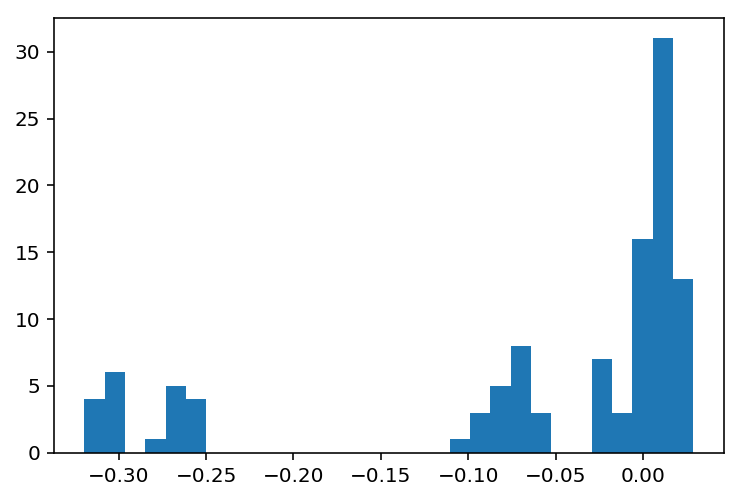

In [59]:
plt.hist(df_model_stats_art['diff'], bins=30)

Text(0.5, 1.0, 'Real coefficient vs. coefficient on artificial lexicons after 1 sound change')

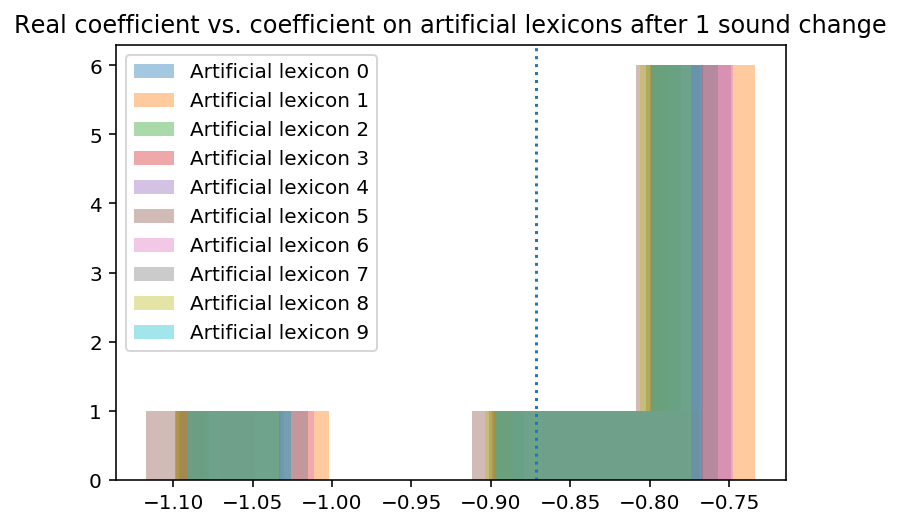

In [42]:
for i in range(10):
    df_tmp = df_model_stats_art[df_model_stats_art['n']==i]
    plt.hist(df_tmp['num_sylls_est'], label="Artificial lexicon {x}".format(x=i), alpha = .4)
    
plt.axvline(baseline_model_stats['num_sylls_est'].values, linestyle="dotted")
plt.legend()
plt.title("Real coefficient vs. coefficient on artificial lexicons after 1 sound change")

In [43]:
df_model_stats_art['vowel_shift'] = df_model_stats_art['rule'].apply(lambda x: tuple(x.split(" --> ")) in great_vowel_shift)

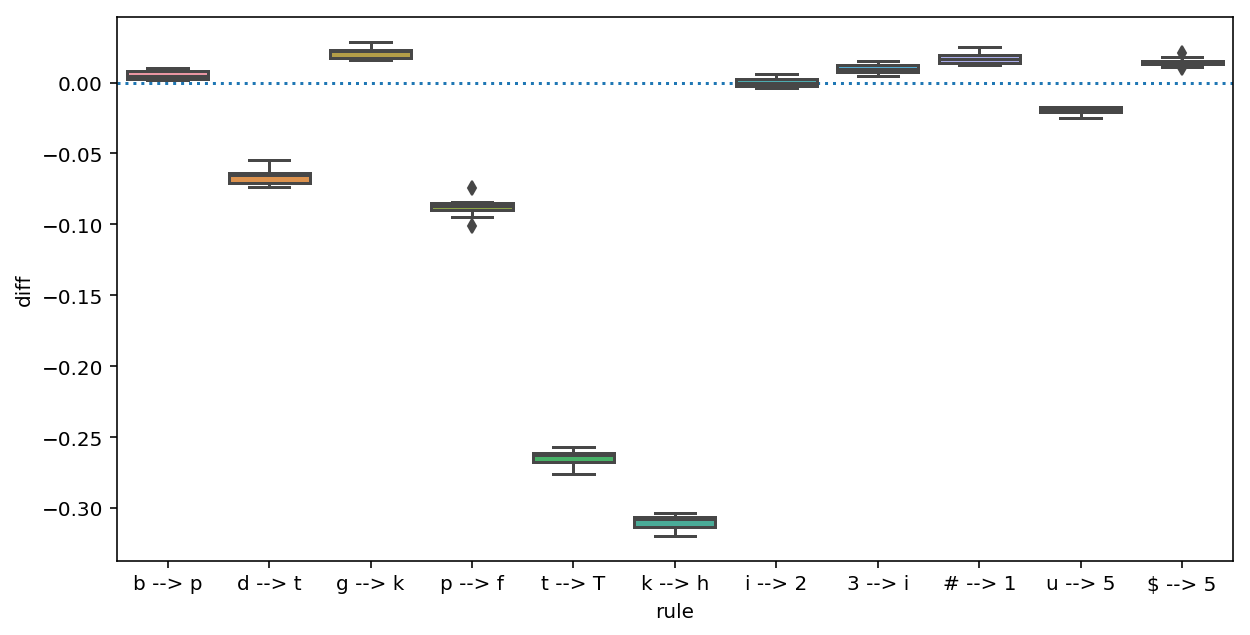

In [60]:
plt.figure(figsize=(10,5))
plt.xlabel("Rule")
plt.ylabel("Difference in slope coefficient")
plt.axhline(y = 0, linestyle = "dotted")

sns.boxplot(data = df_model_stats_art,
            x = "rule",
            y = "diff")

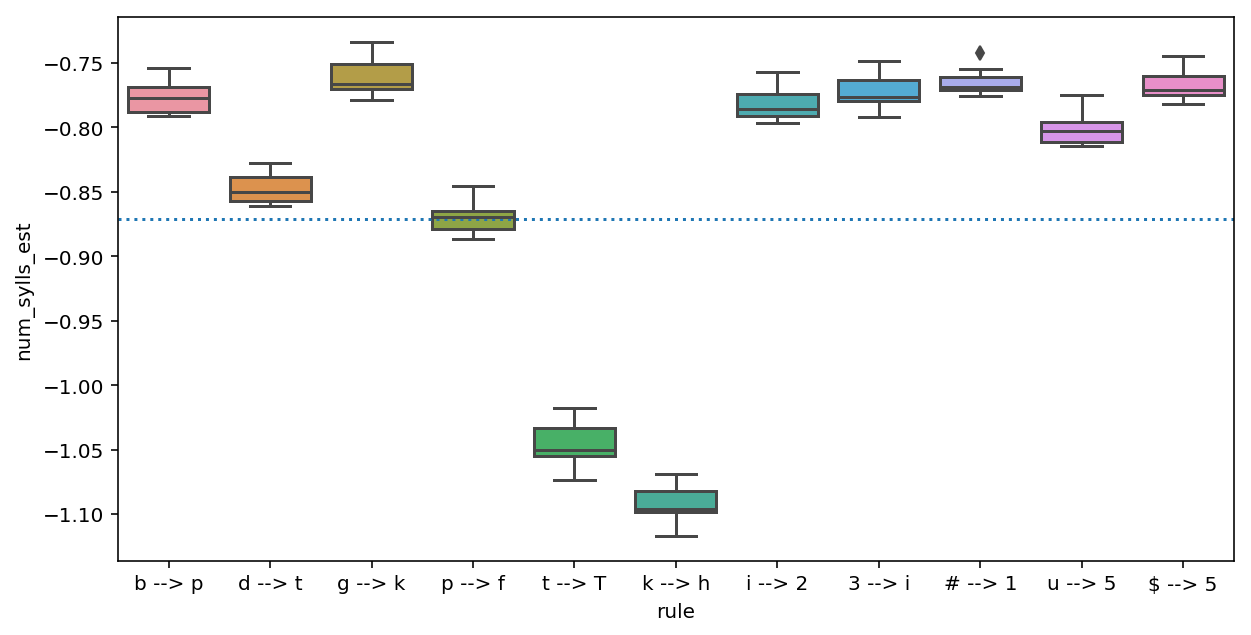

In [46]:
plt.figure(figsize=(10,5))
plt.xlabel("Rule")
plt.ylabel("Difference in slope coefficient")
plt.axhline(y = baseline_model_stats['num_sylls_est'].values, linestyle = "dotted")
sns.boxplot(data = df_model_stats_art,
            x = "rule",
            y = "num_sylls_est")

### Serial sound changes

Now the question is: How many sound changes, applied in succession to a given lexicon, does it take to match the coefficient of `num_syllables` for the real lexicon? 

E.g., given the distribution of slope coefficients from the artificial lexicons (see below), how many times does each lexicon need to undergo phonological mergers in order to display the same relationship as the real lexicon?

In [73]:
real_syl_coef = round(baseline_model_stats['num_sylls_est'].values[0], 2)
print("Real coefficient is: {x}".format(x=real_syl_coef))

Real coefficient is: -0.87


In [74]:
real_surprisal_coef = round(baseline_model_stats['surprisal'].values[0], 2)
print("Real surprisal coefficient is: {x}".format(x=real_surprisal_coef))

Real surprisal coefficient is: -0.2


Text(-0.87, 2, '-0.87')

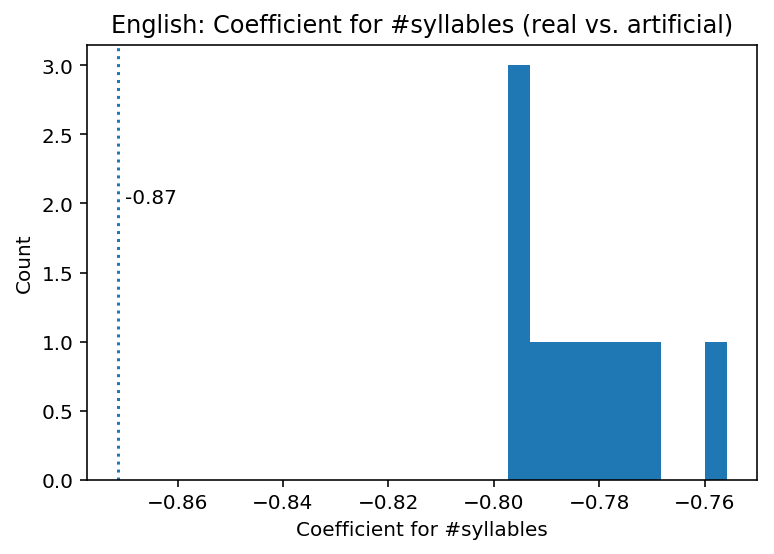

In [75]:
utils.plot_real_vs_art(df_artificial_baseline_models['num_sylls_est'], baseline_model_stats['num_sylls_est'].values,
                        'Coefficient for #syllables', language="English")
plt.text(x = real_syl_coef, s=real_syl_coef, y=2)

In [77]:
lengths = []
for N, baseline_df in enumerate(individual_artificials):
    
    baseline_processed = utils.preprocess_for_analysis(baseline_df, phon_column='word', word_column="word")
    baseline_stats_results = utils.analyze_stats_for_single(baseline_processed, formula=FORMULA, covariates=COVARIATES)
    og_syl_coef = baseline_stats_results['num_sylls_est'].values[0]
    og_surprisal = baseline_stats_results['surprisal'].values[0]
    
    # for iteration in tqdm(list(range(100))):
    for iteration in tqdm(list(range(20))):
        random.shuffle(potential_swaps)
        chain = []
        for index, rule in enumerate(potential_swaps):
            # print("{x1} --> {x2}".format(x1=rule[0], x2=rule[1]))
            chain.append(rule)
            baseline_df, new_lexicon_stats, model_stats = apply_sound_change(baseline_df, rule)

            syl_est = model_stats['num_sylls_est'].values[0]
            surprisal_est = model_stats['surprisal'].values[0]

            if syl_est <= real_syl_coef:
                lengths.append({
                    'N': N,
                    'num_changes': index + 1,
                    'diff_achieved': syl_est - og_syl_coef,
                    'og_coef': og_syl_coef,
                    'og_surprisal': og_surprisal,
                    'num_sylls_est': syl_est,
                    'surprisal_est': surprisal_est,
                    'chain': chain
                    
                })
                break


100%|██████████| 20/20 [02:48<00:00,  7.72s/it]

100%|██████████| 20/20 [04:01<00:00, 10.15s/it]

 75%|███████▌  | 15/20 [03:22<00:59, 11.93s/it]

KeyboardInterrupt: 

In [78]:
df_lengths = pd.DataFrame(lengths)

In [81]:
print(df_lengths['num_changes'].mean())
print(df_lengths['num_changes'].std())

3.8181818181818183
2.2285264114050714
